In [1]:
%pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

Note: you may need to restart the kernel to use updated packages.


In [26]:
from datasets import load_dataset 

dataset = load_dataset("generative-newsai/news-unmasked", split="train")

Found cached dataset parquet (/home/acm/.cache/huggingface/datasets/generative-newsai___parquet/generative-newsai--news-unmasked-afc734a91f0700d7/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


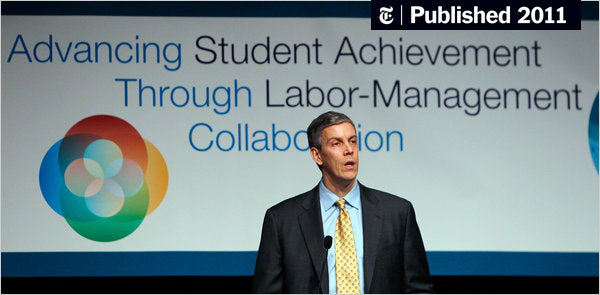

In [27]:
dataset[0]['image']

In [4]:
dataset[0]['section']

'Education'

In [28]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding='max_length', return_tensors='pt')
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding['section'] = item['section']
        return encoding

def collate_fn(batch):
    processed_batch = {}
    for key in batch[0].keys():
        if key != "section":
            processed_batch["pixel_values"] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["section"] for example in batch], padding=True, return_tensors='pt'
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

In [6]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration

processor = AutoProcessor.from_pretrained('Salesforce/blip2-opt-2.7b')
model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", 
                                                      device_map='cuda')

2023-11-13 05:31:47.855686: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 05:31:47.874024: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 05:31:47.874038: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 05:31:47.874050: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 05:31:47.877526: I tensorflow/core/platform/cpu_feature_g

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [29]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias='none',
    target_modules=['q_proj', 'k_proj']
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.13981301102065136


In [31]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)

In [33]:
import torch

optimizer = torch.optim.Adam(model.parameters(), lr=3e-6)

device = "cuda" if torch.cuda.is_available() else "cpu"

model.train()

for epoch in range(1):
    print('Epoch:', epoch)
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device, torch.bfloat16)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)

        loss = outputs.loss

        print('Loss:', loss.item())

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()


Epoch: 0
Loss: 10.817787170410156
Loss: 10.035356521606445
Loss: 9.280407905578613
Loss: 8.608278274536133
Loss: 7.8434882164001465
Loss: 9.483893394470215
Loss: 10.042606353759766
Loss: 8.65860366821289
Loss: 10.24169921875
Loss: 10.292457580566406
Loss: 10.0929536819458
Loss: 10.229096412658691
Loss: 6.739539623260498
Loss: 11.564949989318848
Loss: 9.25316047668457
Loss: 8.035157203674316
Loss: 9.823942184448242
Loss: 7.062188625335693
Loss: 10.631613731384277
Loss: 10.041015625
Loss: 7.436319828033447
Loss: 7.143446445465088
Loss: 5.741430282592773
Loss: 3.8182106018066406
Loss: 10.394730567932129
Loss: 11.154475212097168
Loss: 11.026020050048828
Loss: 10.4133882522583
Loss: 8.960578918457031
Loss: 8.562847137451172
Loss: 9.160497665405273
Loss: 9.940789222717285
Loss: 9.256637573242188
Loss: 8.263301849365234
Loss: 10.978717803955078
Loss: 10.033219337463379
Loss: 9.17166519165039
Loss: 9.415983200073242
Loss: 6.19760274887085
Loss: 7.135883808135986
Loss: 9.272851943969727
Loss: 6

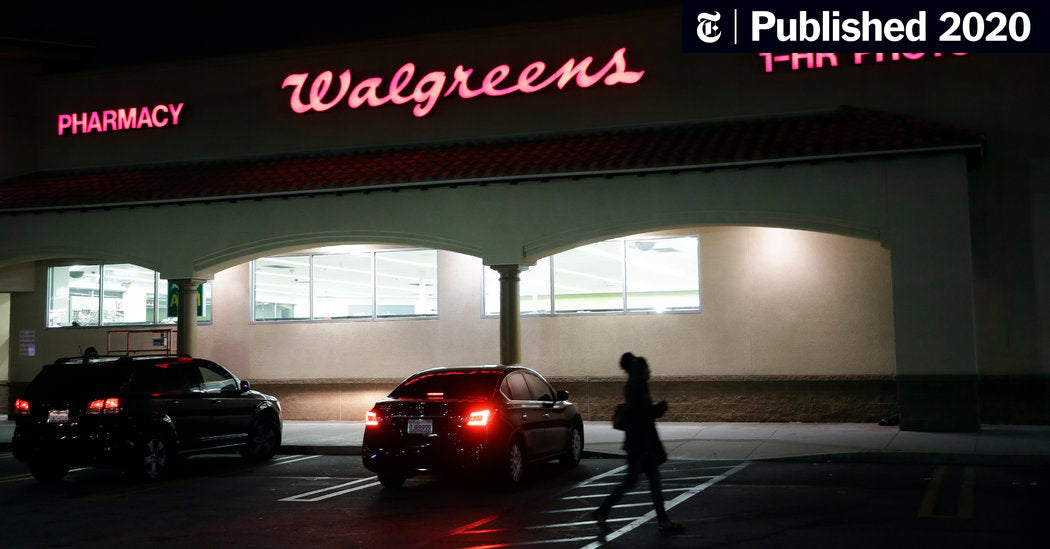

In [45]:
example = dataset[200]
image = example["image"]
image

In [46]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

Health citizern



In [ ]:
!mv Image\ Captioning\ Fine-Tuning.ipynb BLIP2-NYT